# Project setting and Dataset preparation

In [1]:
import torch

# Local GPU Test

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.5.1
True
NVIDIA GeForce RTX 3090


In [2]:
import objaverse

uids = objaverse.load_uids() # each object has a unique ID (uid), then load it
print("all of objects length :", len(uids))

lvis_annotations = objaverse.load_lvis_annotations()

num_of_objects = 10
filtered_lvis_annotations = {key: value for key, value in lvis_annotations.items() if len(value) >= num_of_objects}
print(f"the number of classes having items more than {num_of_objects} : {len(filtered_lvis_annotations)}")

all of objects length : 798759
the number of classes having items more than 10 : 1061


In [18]:
my_datasets = {}

for key, value in filtered_lvis_annotations.items():
    sampled_uids = value[:num_of_objects]
    my_datasets[key] = sampled_uids
    print(f"{key} has {len(sampled_uids)} items : {sampled_uids}")
print(f"This dataset consists of {len(my_datasets)} classes.")

Bible has 10 items : ['ee7660359dda4c90990cb7440211b873', '3e5393bd35e34531a576e22d45611060', 'f5bf29193be44caaad2df1db3db44871', 'adde1e2669d14286843bc9f1cff9ae45', 'f0ed46d723dd441bb592d715db241097', '9d3007d40ca84bb7baec1f1a04e0f08d', '797e7c7f61104b6785c3bd0fdb99c74d', '149d47c6c27648a6af26d6c912c03826', '8257772b0e2f408ba269264855dfea00', 'e7b30aa0ad754744bb5344bc86bf794a']
CD_player has 10 items : ['b4af2a721b1645ddb77168d5e8fe4882', '830b1864b50e4f7e94c7f5cee5b64b43', '639a89472cfa4794b848175bbf652136', '00a66884dacb498b85701acd1cc77c5e', 'dbf0dbcf4229429088b0a984e8f05666', '6914d1e81eeb4377b61af0e5321ede5b', '73e76edb90914783b0fd732ea53b2e46', '9749f5ba1221476993376a3cb8fee1a5', 'f6c8386e76e54918b551ebdd276479dd', 'a4bc4accb20b43ffa728a7a85b7dfed7']
Christmas_tree has 10 items : ['e283aa7835664a74a4ad39afb26d2ef3', 'ae0c3996ee0345aaa8bbb717db7ffb25', 'fe2b4a2708334ff880f62a947cfd3d50', '2da008c410be42d188a0c95aa1bca05e', '16fbadc669454c26aa0927445b3c6ffd', '0b1b92d6d5584284b59a

In [4]:
# once you download the datasets, you don't need to run it again.

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

count = 1
for key, value in my_datasets.items():
    print(f"\nDownloading {key}... ({count} / {len(my_datasets)})")
    objaverse.load_objects(value, 1)
    print(f"Downloading {key} done.\n")
    count += 1

print("All downloading are done.")

KeyboardInterrupt: 

In [4]:
import trimesh
import json
import gzip
import pyrender
import numpy as np
import os
from PIL import Image

class Renderer:
    def __init__(self, path_file, output_path):
        self.my_datasets = my_datasets # key : a class, value : a list of uids
        self.base_path = os.path.join("D:\Sehyeon\Datasets\objaverse", "hf-objaverse-v1")
        with gzip.open(path_file, 'rt') as f:
            self.object_paths = json.load(f)
        self.output_path = output_path
        
    def load_mesh(self, uid):
        # load 3D .glb mesh from its UID
        mesh_path = os.path.join(self.base_path, self.object_paths[uid])
        if not mesh_path or not os.path.exists(mesh_path):
            print(f"Model file not found for UID: {uid}")
            return None
        
        # normalize the mesh to fit inside a 2*2*2 cube centered at (0,0,0)
        try:
            mesh = trimesh.load(mesh_path, force='mesh')
            centroid = mesh.bounds.mean(axis=0)        
            mesh.apply_translation(-centroid)
            
            max_extent = mesh.extents.max()
            scale_factor = 2.0 / max_extent
            
            mesh.apply_scale(scale_factor)
            
        except Exception as e:
            print(f"Error loading mesh: {e}")
            print(f"This mesh is not available 1(UID: {uid}), Error : {e}")
            return None
        
        return mesh
    
    def render_mesh(self, uid, mesh, camera_pos=[[2.5, 1.0, 2.5], [-2.5, 1.0, 2.5], [-2.5, 1.0, -2.5], [2.5, 1.0, -2.5]], 
                    image_size=(512, 512)):
        
        try:
            scene = pyrender.Scene()
            mesh = pyrender.Mesh.from_trimesh(mesh)
            scene.add(mesh)
            
            camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, name="camera")
            light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0, name="light")
            
        except Exception as e:
            print(f"This mesh is not available 2(UID: {uid}), Error : {e}")
            return None    
        
        images = []
        
        for c_pos in camera_pos:
            # Set camera pose
            # Calculate camera pose to look at the origin
            eye = np.array(c_pos)
            target = np.array([0.0, 0.0, 0.0])  # Look at the origin
            up = np.array([0.0, 1.0, 0.0])  # Define the up direction

            # Compute the camera view matrix
            z_axis = (eye - target) / np.linalg.norm(eye - target) # Forward
            x_axis = np.cross(up, z_axis) / np.linalg.norm(np.cross(up, z_axis)) # Right
            y_axis = np.cross(z_axis, x_axis) # Up

            camera_pose = np.eye(4)
            camera_pose[:3, :3] = np.vstack([x_axis, y_axis, z_axis]).T
            camera_pose[:3, 3] = eye
            

            # Render the scene
            try:
                camera_node = scene.add(camera, pose=camera_pose)
                light_node = scene.add(light, pose=camera_pose)
                r = pyrender.OffscreenRenderer(*image_size)
                color, _ = r.render(scene)
                images.append(Image.fromarray(color))
                
                scene.remove_node(camera_node)
                scene.remove_node(light_node)
            except Exception as e:
                print(f"This mesh is not available 3(UID: {uid}), Error : {e}")
                return None
                
        return images
    
    def process_dataset(self):
        cls_count = 1
        for cls, uids in self.my_datasets.items():
            print(f"\nProcessing {cls}... {cls_count} / {len(my_datasets)}")
            
            class_dir = os.path.join(self.output_path, cls)
            os.makedirs(class_dir, exist_ok=True)
            
            for uid in uids:
                img_exists = True
                for i in range(4):
                    img_path = os.path.join(class_dir, f"{uid}_{i}.png") # class path + img name
                    if os.path.exists(img_path):
                        print(f"The file {img_path} already exists.")
                    else:
                        img_exists = False
                        break
                
                if img_exists is False:
                    mesh = self.load_mesh(uid)
                    if mesh is None:
                        continue
                    images = self.render_mesh(uid, mesh)
                    if images is None:
                        continue
                    
                    for i, img in enumerate(images):
                        img_path = os.path.join(class_dir, f"{uid}_{i}.png")
                        try:
                            img.save(img_path)
                            print(f"Saved {uid}_{i}.png")
                        except Exception as e:
                            print(f"Error saving image: {e}")
            
            cls_count += 1
        
        print("Rendering completed!")

In [6]:
# once you rendered the images, you don't need to run it again.

renderer = Renderer("D:\Sehyeon\Datasets\objaverse\hf-objaverse-v1\object-paths.json.gz", "D:\Sehyeon\Datasets\output")
renderer.process_dataset()


Processing airplane... 1 / 76
The file D:\Sehyeon\Datasets\output\airplane\3ca2f507a0a749799e16a4eee12e456c_0.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\3ca2f507a0a749799e16a4eee12e456c_1.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\3ca2f507a0a749799e16a4eee12e456c_2.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\3ca2f507a0a749799e16a4eee12e456c_3.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\2ae974bf45a3436c9d2a6d5e4bdca385_0.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\2ae974bf45a3436c9d2a6d5e4bdca385_1.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\2ae974bf45a3436c9d2a6d5e4bdca385_2.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\2ae974bf45a3436c9d2a6d5e4bdca385_3.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\c6c08606ed24421f82c465eda33bb6ee_0.png already exists.
The file D:\Sehyeon\Datasets\output\airplane\c6c08606ed24421f82c465ed

# Training(Fine-tuning) CLIP

In [16]:
import json
import os

img_base_path = "D:\Sehyeon\Datasets\output"
img_class_datasets = []

for cls, uids in my_datasets.items():
    for uid in uids:
        for i in range(4):
            img_path = os.path.join(img_base_path, cls, f"{uid}_{i}.png")
            if not os.path.exists(img_path):
                print(f"The file {img_path} doesn't exists.")
                break
            temp = {"image": img_path, "label": cls}
            img_class_datasets.append(temp)

# check whether the datasets is correctly constructed 
print(img_class_datasets[:100])

dataset_json_path = os.path.join(img_base_path, "datasets.json")
with open(dataset_json_path, "w", encoding="utf-8") as f:
    json.dump(img_class_datasets, f, indent=4)
    

The file D:\Sehyeon\Datasets\output\antenna\5bffc51e8d084b31b191640f665b8094_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\car_(automobile)\03a8e85c81ad4080ba60f9a0cba95bf7_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\car_(automobile)\ad295df397ac49bf98ff0e656f2d9d0b_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\car_(automobile)\32f9cc11f3f24d34ae11e5da74a7004e_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\chair\c6e96a81319e4f568a32ed540d695041_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\chandelier\7025c342daaf437092f75007837be956_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\chandelier\ec0ee0b69b6a4400a59a7b1bd99c80c5_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\chandelier\507bd3d84b964ef18ba9a608e2a168d0_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\chandelier\6a3e9d4c8c3a4d8a8b4c672a9c18ed87_0.png doesn't exists.
The file D:\Sehyeon\Datasets\output\chandelier\0bc5df4461a244e69d8afd3fa

In [17]:
from datasets import load_dataset

dataset = load_dataset("json", data_files=dataset_json_path)

dataset = dataset["train"].train_test_split(train_size=0.9, shuffle=True, seed=42)
print(dataset["train"])
print(dataset["test"])

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 27176
})
Dataset({
    features: ['image', 'label'],
    num_rows: 3020
})


In [5]:
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [18]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataset, clip_processor, is_train):
        self.dataset = dataset
        self.is_train = is_train
        self.clip_processor = clip_processor
        self.class_texts = [
            f"A photo of a {cls}." for cls in set(dataset["label"])
        ]
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.dataset[idx]["image"]
        label = self.dataset[idx]["label"]

        image = Image.open(image_path).convert("RGB")
        text = f"A photo of a {label}."
        
        return {"image": image, "label": label, "text": text}

    def preprocess(self, batch):
        images = [data["image"] for data in batch]
        texts = [data["text"] for data in batch]
        labels = [data["label"] for data in batch]

        inputs = self.clip_processor(text=texts, images=images, return_tensors="pt", padding=True)

        return {
            "text": texts,
            "label": labels,
            **inputs,
        }

In [19]:
train_dataset = dataset["train"]
train_dataset = CustomDataset(train_dataset, clip_processor, is_train=True)
print(train_dataset.class_texts)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=256,
    shuffle=True,
    collate_fn=train_dataset.preprocess
)

test_dataset = dataset["test"]
test_dataset = CustomDataset(test_dataset, clip_processor, is_train=False)
print(test_dataset.class_texts)

test_dataloader = DataLoader(test_dataset, 
    batch_size=256,
    shuffle=True, 
    collate_fn=test_dataset.preprocess)

['A photo of a sunglasses.', 'A photo of a wolf.', 'A photo of a shield.', 'A photo of a crab_(animal).', 'A photo of a die.', 'A photo of a chandelier.', 'A photo of a skateboard.', 'A photo of a spectacles.', 'A photo of a antenna.', 'A photo of a frog.', 'A photo of a shark.', 'A photo of a fireplug.', 'A photo of a butterfly.', 'A photo of a ring.', 'A photo of a helicopter.', 'A photo of a wineglass.', 'A photo of a owl.', 'A photo of a snowman.', 'A photo of a figurine.', 'A photo of a mug.', 'A photo of a gun.', 'A photo of a bookcase.', 'A photo of a sculpture.', 'A photo of a race_car.', 'A photo of a machine_gun.', 'A photo of a monitor_(computer_equipment) computer_monitor.', 'A photo of a lion.', 'A photo of a doughnut.', 'A photo of a sword.', 'A photo of a pickup_truck.', 'A photo of a apple.', 'A photo of a spider.', 'A photo of a crate.', 'A photo of a mask.', 'A photo of a mushroom.', 'A photo of a teddy_bear.', 'A photo of a motor_vehicle.', 'A photo of a rifle.', 'A 

In [20]:
import torch.nn.functional as F

def loss_fn(logits_per_image, logits_per_text):
    assert logits_per_image.shape[0] == logits_per_image.shape[0]
    assert logits_per_image.shape == logits_per_text.shape
    
    labels = torch.arange(logits_per_image.shape[0], device="cuda")
    loss_i = F.cross_entropy(logits_per_image, labels) # 0, 1, 2, ..., n
    loss_t = F.cross_entropy(logits_per_image, labels) # 0, 1, 2, ..., n
    loss = (loss_i + loss_t) / 2
    
    return loss

In [21]:
from torch.optim import AdamW
from tqdm import tqdm

clip_model.to("cuda")
optimizer = AdamW(clip_model.parameters(), lr=5e-6)
clip_model.train()

num_epochs = 5
for epoch in tqdm(range(1, num_epochs+1), position=0, desc="epoch"):
    for batch in tqdm(train_dataloader, position=0, desc="batch", leave=False):
        optimizer.zero_grad()
 
        outputs = clip_model(
            pixel_values=batch["pixel_values"].to("cuda"),
            input_ids=batch["input_ids"].to("cuda"),
            attention_mask=batch["attention_mask"].to("cuda"),
        )
 
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        loss = loss_fn(logits_per_image, logits_per_text)
        loss.backward()
                
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss:.4f}")

epoch:  20%|██        | 1/5 [04:26<17:45, 266.37s/it]   

Epoch 1, Loss: 0.3968


epoch:  40%|████      | 2/5 [07:54<11:36, 232.21s/it]   

Epoch 2, Loss: 0.2957


epoch:  60%|██████    | 3/5 [11:22<07:21, 220.90s/it]   

Epoch 3, Loss: 0.2561


epoch:  80%|████████  | 4/5 [14:46<03:34, 214.50s/it]   

Epoch 4, Loss: 0.3707


epoch: 100%|██████████| 5/5 [18:08<00:00, 217.69s/it]   

Epoch 5, Loss: 0.2438


# Test fine-tuned CLIP

In [22]:
import torch.nn.functional as F

all_class_texts = clip_processor.tokenizer(test_dataset.class_texts, padding=True)
all_class_texts = {k: torch.tensor(v, device="cuda") for k, v in all_class_texts.items()}
# print(all_class_texts)

class_to_idx = {}
for i, text in enumerate(test_dataset.class_texts):
    cls = text[len("A photo of a "):-1]
    class_to_idx[cls] = i

clip_model.eval()
correct_count = 0
ce_loss_sum = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        outputs = clip_model(
            pixel_values=batch["pixel_values"].to("cuda"),
            **all_class_texts,
        )
        
        probs = outputs.logits_per_image.cpu().softmax(dim=1)
        pred = probs.argmax(dim=1)
        # print("prediction :", pred)
        label = torch.tensor([class_to_idx[lbl] for lbl in batch["label"]])
        # print("labels :", label)
 
        correct_count += (pred == label).sum().item()
        ce_loss_sum += F.cross_entropy(probs, label).item()
    
accuracy = correct_count / len(test_dataloader.dataset)
ce_loss = ce_loss_sum / len(test_dataloader)
print(f"Test CE loss: {ce_loss:.4}, Test accuracy: {(accuracy * 100):.4}%")

100%|██████████| 12/12 [00:33<00:00,  2.78s/it]

Test CE loss: 3.404, Test accuracy: 95.76%


# Test non-fine-tuned CLIP

In [1]:
import torch

# Local GPU Test

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.5.1
True
NVIDIA GeForce RTX 3090


In [2]:
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
import torch
import trimesh
import pyrender
import numpy as np
from PIL import Image

class RendererWithCLIP():
    def __init__(self, mesh_path, text_query, clip_model, clip_processor):
        clip_model.to("cuda")
        
        self.mesh_path = mesh_path
        self.text_query = text_query
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        
    def load_mesh(self):
        if not self.mesh_path or not os.path.exists(self.mesh_path):
            print(f"Model file not found")
            return None
        
        # normalize the mesh to fit inside a 2*2*2 cube centered at (0,0,0)
        try:
            mesh = trimesh.load(self.mesh_path, force='mesh')
            centroid = mesh.bounds.mean(axis=0)        
            mesh.apply_translation(-centroid)
            
            max_extent = mesh.extents.max()
            scale_factor = 2.0 / max_extent
            
            mesh.apply_scale(scale_factor)
            
        except Exception as e:
            print(f"Error loading mesh: {e}")
            return None
        
        return mesh
    
    def render_mesh(self, mesh, camera_pos=[2.5, 1.0, 2.5], image_size=(512, 512)):
        try:
            scene = pyrender.Scene()
            mesh = pyrender.Mesh.from_trimesh(mesh)
            scene.add(mesh)
            
            camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, name="camera")
            light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0, name="light")
            
        except Exception as e:
            print(f"This mesh is not available 1")
            return None
        
        eye = np.array(camera_pos)
        target = np.array([0.0, 0.0, 0.0])
        up = np.array([0.0, 1.0, 0.0])

        # Compute the camera view matrix
        z_axis = (eye - target) / np.linalg.norm(eye - target) # Forward
        x_axis = np.cross(up, z_axis) / np.linalg.norm(np.cross(up, z_axis)) # Right
        y_axis = np.cross(z_axis, x_axis) # Up

        camera_pose_matrix = np.eye(4)
        camera_pose_matrix[:3, :3] = np.vstack([x_axis, y_axis, z_axis]).T
        camera_pose_matrix[:3, 3] = eye
        
        # Render the scene
        try:
            camera_node = scene.add(camera, pose=camera_pose_matrix)
            light_node = scene.add(light, pose=camera_pose_matrix)
            r = pyrender.OffscreenRenderer(*image_size)
            color, _ = r.render(scene)
            
            return Image.fromarray(color)
            
        except Exception as e:
            print(f"This mesh is not available 2")
            return None

    def predict_from_3d_model(self):
        # Load the 3D mesh
        mesh = self.load_mesh()
        if mesh is None:
            print(f"Failed to load mesh")
            return None, None

        # Render the mesh into multiple views
        image = self.render_mesh(mesh)
        if image is None:
            print(f"Failed to render images for UID: {uid}")
            return None, None

        # Prepare the images for CLIP
        inputs = self.clip_processor(text=self.text_query, images=image, return_tensors="pt", padding=True).to("cuda")

        # Predict with CLIP
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            
            predicted_class_idx = torch.argmax(probs[0]).item()
            predicted_text = self.text_query[predicted_class_idx]

        return image, predicted_text

In [4]:
import objaverse

uids = objaverse.load_uids() # each object has a unique ID (uid), then load it
print("all of objects length :", len(uids))

lvis_annotations = objaverse.load_lvis_annotations()

num_of_objects = 10
filtered_lvis_annotations = {key: value for key, value in lvis_annotations.items() if len(value) >= num_of_objects}
print(f"the number of classes having items more than {num_of_objects} : {len(filtered_lvis_annotations)}")

my_datasets = {}

for key, value in filtered_lvis_annotations.items():
    sampled_uids = value[:num_of_objects]
    my_datasets[key] = sampled_uids
    print(f"{key} has {len(sampled_uids)} items : {sampled_uids}")

all of objects length : 798759
the number of classes having items more than 10 : 1061
Bible has 10 items : ['ee7660359dda4c90990cb7440211b873', '3e5393bd35e34531a576e22d45611060', 'f5bf29193be44caaad2df1db3db44871', 'adde1e2669d14286843bc9f1cff9ae45', 'f0ed46d723dd441bb592d715db241097', '9d3007d40ca84bb7baec1f1a04e0f08d', '797e7c7f61104b6785c3bd0fdb99c74d', '149d47c6c27648a6af26d6c912c03826', '8257772b0e2f408ba269264855dfea00', 'e7b30aa0ad754744bb5344bc86bf794a']
CD_player has 10 items : ['b4af2a721b1645ddb77168d5e8fe4882', '830b1864b50e4f7e94c7f5cee5b64b43', '639a89472cfa4794b848175bbf652136', '00a66884dacb498b85701acd1cc77c5e', 'dbf0dbcf4229429088b0a984e8f05666', '6914d1e81eeb4377b61af0e5321ede5b', '73e76edb90914783b0fd732ea53b2e46', '9749f5ba1221476993376a3cb8fee1a5', 'f6c8386e76e54918b551ebdd276479dd', 'a4bc4accb20b43ffa728a7a85b7dfed7']
Christmas_tree has 10 items : ['e283aa7835664a74a4ad39afb26d2ef3', 'ae0c3996ee0345aaa8bbb717db7ffb25', 'fe2b4a2708334ff880f62a947cfd3d50', '2da008

In [5]:
import json
import gzip
import os

path_file = "D:\Sehyeon\Datasets\objaverse\hf-objaverse-v1\object-paths.json.gz"
base_path = os.path.join("D:\Sehyeon\Datasets\objaverse", "hf-objaverse-v1")
with gzip.open(path_file, 'rt') as f:
    object_paths = json.load(f)

In [10]:
import os
import time
import numpy as np

# class_path = "D:\Sehyeon\Datasets\output"
text_query = []

# create list of all classes
for cls in my_datasets.keys():
    text_query.append("A 3D model of a " + cls + ".")

count = 0.0
correct_count = 0.0
for cls, uids in my_datasets.items():
    class_sentence = "A 3D model of a " + cls + "."
    for uid in uids:
        renderer_with_CLIP = RendererWithCLIP(os.path.join(base_path, object_paths[uid]), text_query, clip_model, clip_processor)
        _, clip_result = renderer_with_CLIP.predict_from_3d_model()
        # print(f"{class_sentence} / {clip_result}")
        
        if clip_result is None:
            continue
        if clip_result == class_sentence:
            correct_count += 1.0
        
        count += 1.0
        print(f"Current count : {correct_count} / {count}")

clip_accuracy = (correct_count / count) * 100
print(f"CLIP accuracy : {clip_accuracy:.2}")

Current count : 0.0 / 1.0
Current count : 0.0 / 2.0
Current count : 0.0 / 3.0
Current count : 0.0 / 4.0
Current count : 0.0 / 5.0
Current count : 0.0 / 6.0
Current count : 0.0 / 7.0
Current count : 0.0 / 8.0
Current count : 0.0 / 9.0
Current count : 0.0 / 10.0
Current count : 0.0 / 11.0
Current count : 0.0 / 12.0
Current count : 0.0 / 13.0
Current count : 0.0 / 14.0
Current count : 0.0 / 15.0
Current count : 0.0 / 16.0
Current count : 0.0 / 17.0
Current count : 1.0 / 18.0
Current count : 1.0 / 19.0
Current count : 2.0 / 20.0
Current count : 3.0 / 21.0
Current count : 4.0 / 22.0
Current count : 5.0 / 23.0
Current count : 6.0 / 24.0
Current count : 7.0 / 25.0
Current count : 8.0 / 26.0
Current count : 9.0 / 27.0
Current count : 10.0 / 28.0
Current count : 11.0 / 29.0
Current count : 12.0 / 30.0
Current count : 12.0 / 31.0
Current count : 12.0 / 32.0
Current count : 13.0 / 33.0
Current count : 14.0 / 34.0
Current count : 15.0 / 35.0
Current count : 16.0 / 36.0
Current count : 17.0 / 37.0


C:\Users\shpark\anaconda3\envs\20242R0136COSE47402\Lib\site-packages\trimesh\transformations.py:2316: RuntimeWarning: invalid value encountered in divide
  cross = cross / norm


Current count : 222.0 / 978.0
Current count : 223.0 / 979.0
Current count : 224.0 / 980.0
Current count : 224.0 / 981.0
Current count : 224.0 / 982.0
Current count : 225.0 / 983.0
Current count : 225.0 / 984.0
Current count : 225.0 / 985.0
Current count : 225.0 / 986.0
Current count : 225.0 / 987.0
Current count : 225.0 / 988.0
Current count : 225.0 / 989.0
Current count : 225.0 / 990.0
Current count : 225.0 / 991.0
Current count : 225.0 / 992.0
Current count : 225.0 / 993.0
Current count : 225.0 / 994.0
Current count : 225.0 / 995.0
Current count : 225.0 / 996.0
Current count : 225.0 / 997.0
Current count : 225.0 / 998.0
Current count : 225.0 / 999.0
Current count : 225.0 / 1000.0
Current count : 225.0 / 1001.0
Current count : 225.0 / 1002.0
Current count : 225.0 / 1003.0
Current count : 225.0 / 1004.0
Current count : 225.0 / 1005.0
Current count : 225.0 / 1006.0
Current count : 225.0 / 1007.0
Current count : 225.0 / 1008.0
Current count : 225.0 / 1009.0
Current count : 225.0 / 1010.0

# Using the framework

In [1]:
import torch

# Local GPU Test

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.5.1
True
NVIDIA GeForce RTX 3090


In [2]:
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

from transformers import AutoTokenizer, AutoModelForCausalLM

# Llama-3-2-1B, Llama-3-2-3B, Llama-3-1.8B
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
import torch
import trimesh
import pyrender
import numpy as np
from PIL import Image

class RendererWithCLIP():
    def __init__(self, mesh_path, text_query, clip_model, clip_processor):
        clip_model.to("cuda")
        
        self.mesh_path = mesh_path
        self.text_query = text_query
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        
    def load_mesh(self):
        if not self.mesh_path or not os.path.exists(self.mesh_path):
            print(f"Model file not found")
            return None
        
        # normalize the mesh to fit inside a 2*2*2 cube centered at (0,0,0)
        try:
            mesh = trimesh.load(self.mesh_path, force='mesh')
            centroid = mesh.bounds.mean(axis=0)        
            mesh.apply_translation(-centroid)
            
            max_extent = mesh.extents.max()
            scale_factor = 2.0 / max_extent
            
            mesh.apply_scale(scale_factor)
            
        except Exception as e:
            print(f"Error loading mesh: {e}")
            return None
        
        return mesh
    
    def render_mesh(self, mesh, camera_pos=[2.5, 1.0, 2.5], image_size=(512, 512)):
        try:
            scene = pyrender.Scene()
            mesh = pyrender.Mesh.from_trimesh(mesh)
            scene.add(mesh)
            
            camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, name="camera")
            light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0, name="light")
            
        except Exception as e:
            print(f"This mesh is not available 1")
            return None
        
        eye = np.array(camera_pos)
        target = np.array([0.0, 0.0, 0.0])
        up = np.array([0.0, 1.0, 0.0])

        # Compute the camera view matrix
        z_axis = (eye - target) / np.linalg.norm(eye - target) # Forward
        x_axis = np.cross(up, z_axis) / np.linalg.norm(np.cross(up, z_axis)) # Right
        y_axis = np.cross(z_axis, x_axis) # Up

        camera_pose_matrix = np.eye(4)
        camera_pose_matrix[:3, :3] = np.vstack([x_axis, y_axis, z_axis]).T
        camera_pose_matrix[:3, 3] = eye
        
        # Render the scene
        try:
            camera_node = scene.add(camera, pose=camera_pose_matrix)
            light_node = scene.add(light, pose=camera_pose_matrix)
            r = pyrender.OffscreenRenderer(*image_size)
            color, _ = r.render(scene)
            
            return Image.fromarray(color)
            
        except Exception as e:
            print(f"This mesh is not available 2")
            return None

    def predict_from_3d_model(self):
        # Load the 3D mesh
        mesh = self.load_mesh()
        if mesh is None:
            print(f"Failed to load mesh")
            return None, None

        # Render the mesh into multiple views
        image = self.render_mesh(mesh)
        if image is None:
            print(f"Failed to render images for UID: {uid}")
            return None, None

        # Prepare the images for CLIP
        inputs = self.clip_processor(text=self.text_query, images=image, return_tensors="pt", padding=True).to("cuda")

        # Predict with CLIP
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            
            predicted_class_idx = torch.argmax(probs[0]).item()
            predicted_text = self.text_query[predicted_class_idx]

        return image, predicted_text

In [4]:
import objaverse

uids = objaverse.load_uids() # each object has a unique ID (uid), then load it
print("all of objects length :", len(uids))

lvis_annotations = objaverse.load_lvis_annotations()

num_of_objects = 10
filtered_lvis_annotations = {key: value for key, value in lvis_annotations.items() if len(value) >= num_of_objects}
print(f"the number of classes having items more than {num_of_objects} : {len(filtered_lvis_annotations)}")

my_datasets = {}

for key, value in filtered_lvis_annotations.items():
    sampled_uids = value[:num_of_objects]
    my_datasets[key] = sampled_uids
    print(f"{key} has {len(sampled_uids)} items : {sampled_uids}")

all of objects length : 798759
the number of classes having items more than 10 : 1061
Bible has 10 items : ['ee7660359dda4c90990cb7440211b873', '3e5393bd35e34531a576e22d45611060', 'f5bf29193be44caaad2df1db3db44871', 'adde1e2669d14286843bc9f1cff9ae45', 'f0ed46d723dd441bb592d715db241097', '9d3007d40ca84bb7baec1f1a04e0f08d', '797e7c7f61104b6785c3bd0fdb99c74d', '149d47c6c27648a6af26d6c912c03826', '8257772b0e2f408ba269264855dfea00', 'e7b30aa0ad754744bb5344bc86bf794a']
CD_player has 10 items : ['b4af2a721b1645ddb77168d5e8fe4882', '830b1864b50e4f7e94c7f5cee5b64b43', '639a89472cfa4794b848175bbf652136', '00a66884dacb498b85701acd1cc77c5e', 'dbf0dbcf4229429088b0a984e8f05666', '6914d1e81eeb4377b61af0e5321ede5b', '73e76edb90914783b0fd732ea53b2e46', '9749f5ba1221476993376a3cb8fee1a5', 'f6c8386e76e54918b551ebdd276479dd', 'a4bc4accb20b43ffa728a7a85b7dfed7']
Christmas_tree has 10 items : ['e283aa7835664a74a4ad39afb26d2ef3', 'ae0c3996ee0345aaa8bbb717db7ffb25', 'fe2b4a2708334ff880f62a947cfd3d50', '2da008

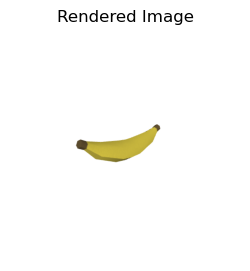

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


result : A 3D model of a banana.
Generated Response:  It is a fruit. It is a food. It is a plant. It is a tree. It is a seed. It is a flower. It is a vegetable. It is a plant. It is a tree.
Time taken for response : 48.209s


In [9]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

# class_path = "D:\Sehyeon\Datasets\output"
text_query = []

# create list of all classes
for cls in my_datasets.keys():
    text_query.append("A 3D model of a " + cls + ".")
        
renderer_with_CLIP = RendererWithCLIP("D:\Sehyeon\Datasets\objaverse\hf-objaverse-v1\glbs\\000-002\\ade2b59ff37c44059433414f39c94abe.glb", text_query, clip_model, clip_processor)
image, clip_result = renderer_with_CLIP.predict_from_3d_model()

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')
plt.title("Rendered Image")
plt.show()

print("result :", clip_result)

start_time = time.time()

llama_model.to("cuda")

clip_result_class_name = clip_result[len("A 3D model of a "):-len(".")]
prompt = f"Here is {clip_result}. Write an objective explanation about what {clip_result_class_name} is, and its uses."

inputs = llama_tokenizer(prompt, return_tensors="pt").to("cuda")
output = llama_model.generate(inputs["input_ids"], max_length=70, num_return_sequences=1, temperature=0.2)

response = llama_tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Response:", response[len(prompt):])

end_time = time.time()
print(f"Time taken for response : {end_time - start_time:.3f}s")